# 2D Navier Stokes fluid-simulation 

In order to create a 2D fluid simulation we used the OpenFOAM 2D lid-driven cavity tutorial as a test-case.

This simulation uses the icoFoam solver with a fixed viscosity term.

The boundary condition on the top of the cavity creates a pressure gradient causing the fluid to swirl.

The goal of this notebook is to load the OpenFOAM data into a NumPy object using the XXXX library created by XXXX.

Once the data is loaded in a python object we will use Matplotlib and its quiver and animation features to visualize the fluid flow.

This data will then act as a test case for a PINN used to model 2D navier stokes fluid flow.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import Ofpp as ofpp
import os
import matplotlib.animation as animation
import math

In [6]:
#Read in key parameters from control dict eventually
start_time = 0
end_time = 5
dt = 0.005
ofoam_write_interval = 1
ofoam_output_inc = dt * ofoam_write_interval
ofoam_num_outputs = ( end_time / ofoam_output_inc ) + 1

openfoam_case_path = "/Users/harry/openfoam/cavity-re100/"

numx = 20
numy = 20
numt = len(np.arange(start_time,end_time + ofoam_output_inc,ofoam_output_inc))
shape = (numx,numy,numt)
print(f"OpenFOAM data shape: {shape}")

print(f"Start: {start_time} end: {end_time}")
print(f"dt: {dt} num timesteps: {numt}")
print(f"Write interval: {ofoam_write_interval} ofoam_num_outputs: {ofoam_num_outputs}")
#print(f"Animation interval: {} animation images: {}")

X, Y = np.meshgrid(np.linspace(0,numx,numy),np.linspace(0,numx,numy))

u_full = np.empty(shape)
v_full = np.empty(shape)
w_full = np.empty(shape)
p_full = np.empty(shape)

openfoam_outputs = os.listdir(openfoam_case_path)
openfoam_outputs.remove("constant")
openfoam_outputs.remove("system")
openfoam_outputs.remove("0_orig")
openfoam_outputs.sort()
openfoam_outputs = openfoam_outputs[::ofoam_write_interval]

idx = 0
for time in openfoam_outputs:
    openfoam_timestep = openfoam_case_path + time
    if time == "0":
        u_full[:-1,:,idx] = 0
        u_full[-1,:,idx] = 1
        
        v_full[:-1,:,idx] = 0
        v_full[-1,:,idx] = 1
        
        p_full[:,:,idx] = 0
    else:
        U = ofpp.parse_internal_field(f"{openfoam_timestep}/U")
        u_full[:,:,idx] = U[:,0].reshape((numx,numy))
        v_full[:,:,idx] = U[:,1].reshape((numx,numy))
        
        p_full[:,:,idx] = ofpp.parse_internal_field(f"{openfoam_timestep}/p").reshape((numx,numy))
    
    idx += 1


OpenFOAM data shape: (20, 20, 1001)
Start: 0 end: 5
dt: 0.005 num timesteps: 1001
Write interval: 1 ofoam_num_outputs: 1001.0


In [9]:
#Spot check that u_full and p_full matches manual read
u_0p005 = ofpp.parse_internal_field("/Users/harry/openfoam/cavity-re100/0.005/U")[:,0].reshape((numx,numy))
print(np.sum(u_full[:,:,1] - u_0p005)) #differences should be 0 if identical

p_0p005 = ofpp.parse_internal_field("/Users/harry/openfoam/cavity-re100/0.005/p").reshape((numx,numy))
print(np.sum(p_full[:,:,1] - p_0p005)) #differences should be 0 if identical


0.0
0.0


In [10]:
#Animation output control
animation_num_outputs = 10
animation_write_interval = math.floor(ofoam_num_outputs / animation_num_outputs)


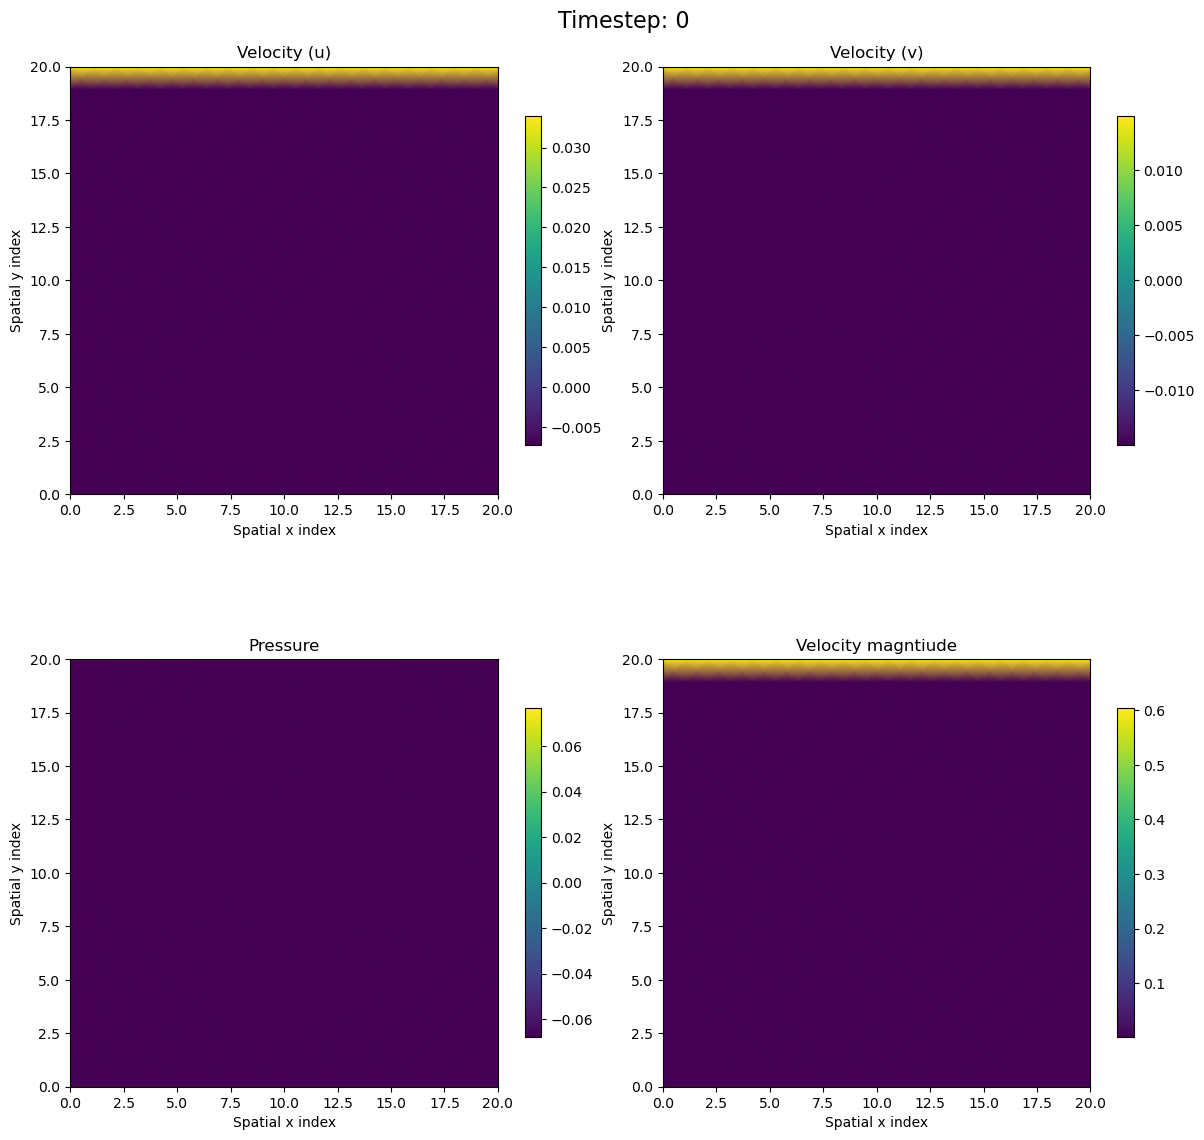

In [11]:
#Takes about 1.5 minutes to compute
fig, ax = plt.subplots(2,2, figsize=(12, 12))
fig.tight_layout()
fig.colorbar(ax[0][0].pcolormesh(X, Y, u_full[:,:,int(1)], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[0][1].pcolormesh(X, Y, v_full[:,:,int(1)], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][0].pcolormesh(X, Y, p_full[:,:,int(1)], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][1].pcolormesh(X, Y, np.sqrt(u_full[:,:,-1]**2 + v_full[:,:,-1]**2), shading='gouraud'), shrink=0.6, orientation='vertical')

u_mag_full = np.sqrt(u_full.astype(np.double)**2 + v_full.astype(np.double)**2).astype(float)

def animate_subplot(i):
    fig.suptitle(f"Timestep: {i*animation_write_interval*ofoam_write_interval}", fontsize=16)
    ax[0][0].pcolormesh(X, Y, u_full[:,:,int(i*animation_write_interval)], shading='gouraud')
    if i != 0:
        ax[0][0].quiver(X,Y,u_full[:,:,int(i*animation_write_interval)],v_full[:,:,int(i*animation_write_interval)])
    ax[0][0].set_title("Velocity (u)")
    ax[0][0].set_ylabel("Spatial y index")
    ax[0][0].set_xlabel("Spatial x index")
    ax[0][0].set_box_aspect(1)

    ax[0][1].pcolormesh(X, Y, v_full[:,:,int(i*animation_write_interval)], shading='gouraud')
    if i != 0:
        ax[0][1].quiver(X,Y,u_full[:,:,int(i*animation_write_interval)],v_full[:,:,int(i*animation_write_interval)])
    ax[0][1].set_title("Velocity (v)")
    ax[0][1].set_ylabel("Spatial y index")
    ax[0][1].set_xlabel("Spatial x index")
    ax[0][1].set_box_aspect(1)

    ax[1][0].pcolormesh(X, Y, p_full[:,:,int(i*animation_write_interval)], shading='gouraud')
    if i != 0:
        ax[1][0].quiver(X,Y,u_full[:,:,int(i*animation_write_interval)],v_full[:,:,int(i*animation_write_interval)])
    ax[1][0].set_title("Pressure")
    ax[1][0].set_ylabel("Spatial y index")
    ax[1][0].set_xlabel("Spatial x index")
    ax[1][0].set_box_aspect(1)

    ax[1][1].pcolormesh(X, Y, u_mag_full[:,:,int(i*animation_write_interval)], shading='gouraud')
    if i != 0:
        ax[1][1].quiver(X,Y,u_full[:,:,int(i*animation_write_interval)],v_full[:,:,int(i*animation_write_interval)])
    ax[1][1].set_title("Velocity magntiude")
    ax[1][1].set_ylabel("Spatial y index")
    ax[1][1].set_xlabel("Spatial x index")
    ax[1][1].set_box_aspect(1)

ani = animation.FuncAnimation(fig, animate_subplot, int(animation_num_outputs), interval=1)
ani.save(f'full_openfoam_wi{animation_write_interval}.gif')